In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import warnings
from pathlib import Path
from pandas import date_range

import pycompo.core.composite as pccompo
import pycompo.core.utils as pcutil
import pycompo.core.plot as pcplot
import pycompo.core.significance_testing as pcsig

warnings.filterwarnings(action='ignore')

# read in configuration file
config_file = \
    "/home/m/m300738/libs/pycompo/config/settings_ngc5004_pc08.yaml"
config = pcutil.read_yaml_config(config_file)

start_time = config['data']['analysis_time'][0]
end_time = config['data']['analysis_time'][1]
analysis_times = [
    np.datetime64(t) for t in date_range(
        np.datetime64(start_time), np.datetime64(end_time), freq='MS',
        )
    ]
subgroup_vars = config['composite']['subgroup_vars']
analysis_idf = f"{config['exp']}_{config['pycompo_name']}"

# Calculate composites

### Preparations for composite subsampling

In [ ]:
analysis_times = analysis_times[:3] # Necessary since otherwise too long calculation time

# load feature_props
inpath = Path(f"{config['data']['outpath']}/{analysis_idf}/")
infile_compo = Path(f"{analysis_idf}_feature_props_alltrops_all.nc")
feature_props_alltrops = xr.open_dataset(str(inpath/infile_compo))
feature_props_alltrops_quartiles = feature_props_alltrops.quantile(
    [0.25, 0.50, 0.75]
    )

# build rainbelt if necessary
if config['composite']['rainbelt_subsampling']['switch']:
    rainbelt = pccompo.get_rainbelt(analysis_times, config, quantile=0.8)
    rainbelt = rainbelt.compute()
    infile_compo = Path(f"{analysis_idf}_feature_props_rainbelt_all.nc")
    feature_props_rainbelt = xr.open_dataset(str(inpath/infile_compo))
    feature_props_rainbelt_quartiles = feature_props_rainbelt.quantile(
        [0.25, 0.50, 0.75]
        )

### Read in feature_data

In [ ]:
# ------------------------------------------------------------------------------
# create a single feature composite
# ---------------------------------
inpath = Path(f"{config['data']['outpath']}/{analysis_idf}/features/")
alltrops_compo = []
alltrops_var = []
alltrops_N_features = []
alltrops_quartile_compo = {var: [] for var in subgroup_vars}
if config['composite']['rainbelt_subsampling']['switch']:
    rainbelt_compo = []
    rainbelt_var = []
    rainbelt_N_features = []
    rainbelt_quartile_compo = {var: [] for var in subgroup_vars}

for i in range (len(analysis_times)-1):
    # read in data
    file_timestr = \
        f"{pcutil.np_datetime2file_datestr(analysis_times[i])}-" + \
        f"{pcutil.np_datetime2file_datestr(analysis_times[i+1])}"
    infile_compo = inpath/Path(f"{analysis_idf}_features_{file_timestr}.nc")
    features_alltrops = xr.open_dataset(infile_compo).compute()
    compo_vars = [
        v for v in features_alltrops.data_vars if features_alltrops[v].ndim == 3
        ]
    alltrops_compo.append(features_alltrops.mean(dim='feature'))
    alltrops_var.append(features_alltrops.var(dim='feature', ddof=1))
    alltrops_N_features.append(features_alltrops.sizes['feature'])
    
    # subsample based on BG conditions
    for var in subgroup_vars:
        alltrops_quartile_compo[var].append(
            pccompo.get_quartile_compos_per_ts(
                features_alltrops, feature_props_alltrops_quartiles[var], var,
                )
            )

    # Precipitation-based geographic subsampling
    if config['composite']['rainbelt_subsampling']['switch']:
        features_rainbelt = pccompo.sample_features_geomask(
            features_alltrops, rainbelt,
            )
        rainbelt_compo.append(features_rainbelt.mean(dim='feature'))
        rainbelt_var.append(features_rainbelt.var(dim='feature', ddof=1))
        rainbelt_N_features.append(features_rainbelt.sizes['feature'])
        
        # subsample based on BG conditions
        for var in subgroup_vars:
            rainbelt_quartile_compo[var].append(
                pccompo.get_quartile_compos_per_ts(
                    features_rainbelt, feature_props_alltrops_quartiles[var], var,
                    )
                )

    # Basin-based geographic subsampling
    # TODO: Implement basin-based geographical subsampling
    
alltrops_mean = xr.concat(alltrops_compo, dim='month')
alltrops_var = xr.concat(alltrops_var, dim='month')
alltrops_N_features = xr.DataArray(
    np.array(alltrops_N_features), dims=["month"],
    )
_, alltrops_pvalue = pcsig.yearly_ttest_from_monthly_data(
    alltrops_mean[compo_vars], alltrops_var[compo_vars], alltrops_N_features,
    popmean=0.0,
    )
alltrops_compo = alltrops_mean.mean(dim='month')

for var in subgroup_vars:
    alltrops_quartile_compo[var] = pccompo.get_full_quartile_compos(
        alltrops_quartile_compo[var],
    )
        
if config['composite']['rainbelt_subsampling']['switch']:
    rainbelt_compo = xr.concat(rainbelt_compo, dim='month').mean(dim='month')
    for var in subgroup_vars:
        rainbelt_quartile_compo[var] = pccompo.get_full_quartile_compos(
            rainbelt_quartile_compo[var],
    )

# Read in composites

In [2]:
inpath = Path(f"{config['data']['outpath']}/{analysis_idf}/")

# read in composites
infile_compo = Path(f"{analysis_idf}_composite_alltrops_all.nc")
alltrops_compo = xr.open_dataset(str(inpath/infile_compo))

alltrops_quartile_compo = {}
rainbelt_quartile_compo = {}
for var in subgroup_vars:
    infile_compo = Path(f"{analysis_idf}_composite_alltrops_{var}_quartiles.nc")
    alltrops_quartile_compo[var] = xr.open_dataset(str(inpath/infile_compo))
        
if config['composite']['rainbelt_subsampling']['switch']:
    infile_compo = Path(f"{analysis_idf}_composite_rainbelt_all.nc")
    rainbelt_compo = xr.open_dataset(str(inpath/infile_compo))
    
    for var in subgroup_vars:
        infile_compo = Path(f"{analysis_idf}_composite_rainbelt_{var}_quartiles.nc")
        rainbelt_quartile_compo[var] = xr.open_dataset(str(inpath/infile_compo))

# read in p-values and calculate field significance
infile_pvalue = Path(f"{analysis_idf}_pvalue_alltrops_all.nc")
alltrops_pvalue = xr.open_dataset(str(inpath/infile_pvalue))
alltrops_sigmask = pcsig.get_field_significance(alltrops_pvalue, alpha_FDR=0.1)
if config['composite']['rainbelt_subsampling']['switch']:
    infile_pvalue = Path(f"{analysis_idf}_pvalue_rainbelt_all.nc")
    rainbelt_pvalue = xr.open_dataset(str(inpath/infile_pvalue))
    rainbelt_sigmask = pcsig.get_field_significance(
        rainbelt_pvalue, alpha_FDR=0.1
        )

nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1
nseg = 1


### Visualization of composites

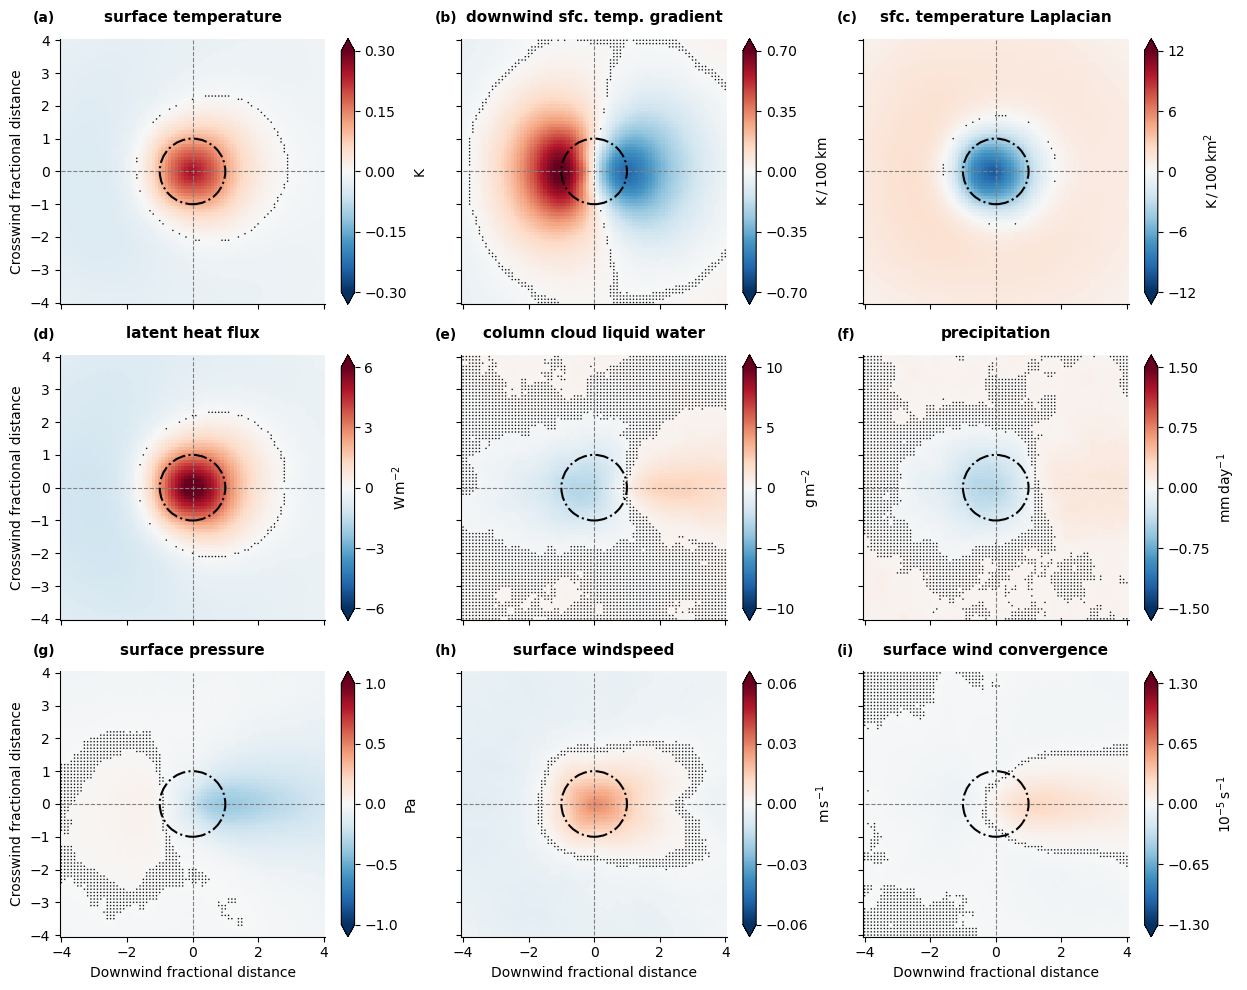

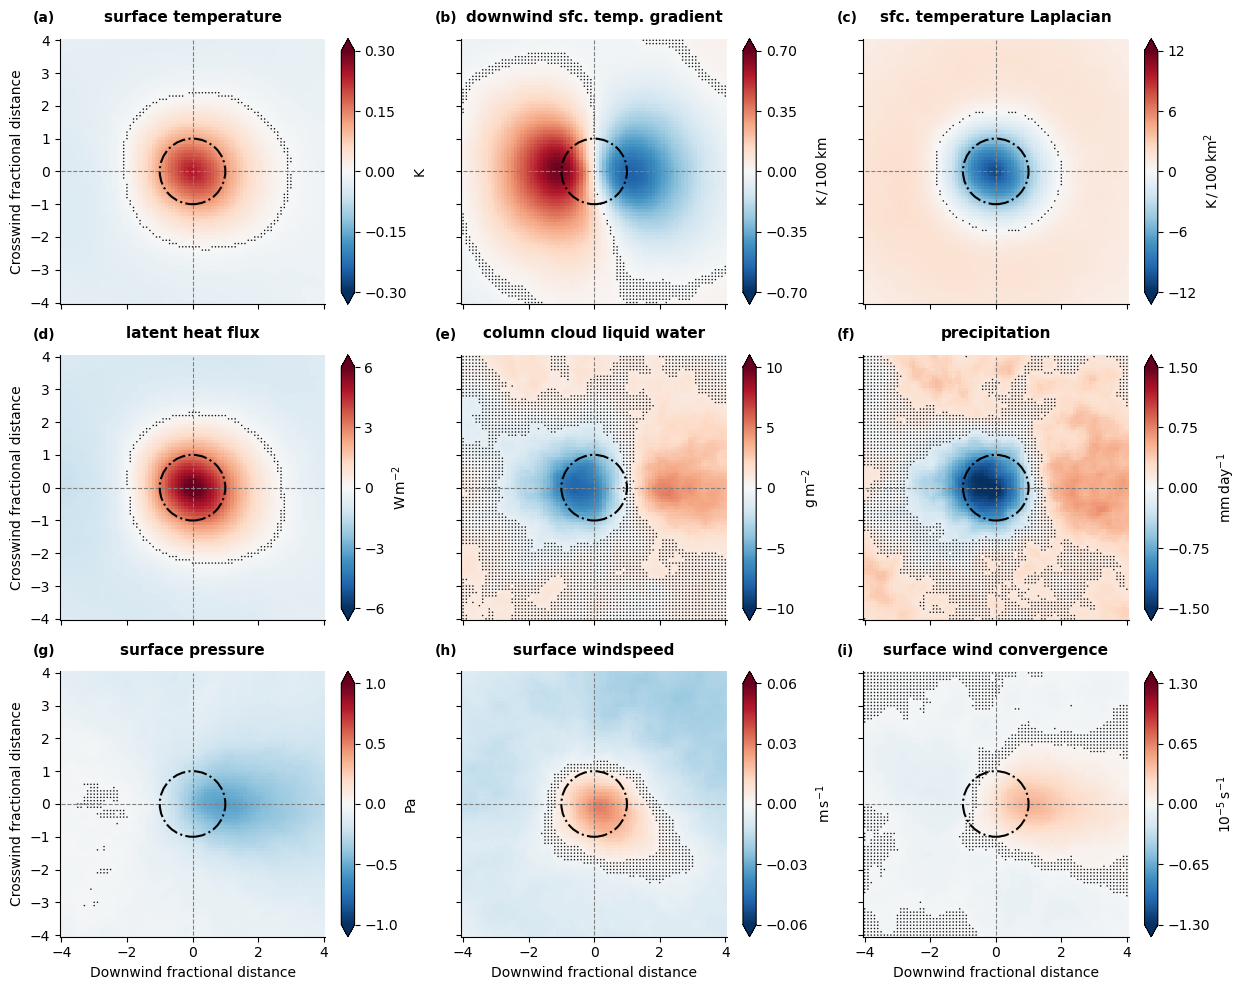

In [4]:
import importlib as implib
implib.reload(pcplot)

outpath = (
    f'/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/' +
    f'{analysis_idf}'
)
Path(outpath).mkdir(parents=True, exist_ok=True)

vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    ]

alltrops_compo_adjusted = pccompo.adjust_units(alltrops_compo, vars)
pcplot.plot_composite_overview(
    alltrops_compo_adjusted, vars=vars, sigmask=alltrops_sigmask,
    )
plt.savefig(
    f'{outpath}/{analysis_idf}_composite_alltrops_overview.png', dpi=600,
    )
plt.show()

rainbelt_compo_adjusted = pccompo.adjust_units(rainbelt_compo, vars)
pcplot.plot_composite_overview(
    rainbelt_compo_adjusted, vars=vars, sigmask=rainbelt_sigmask,
    )
plt.savefig(
    f'{outpath}/{analysis_idf}_composite_rainbelt_overview.png', dpi=600,
    )
plt.show()

In [3]:
# add altitude coordinate aligned with the existing 'height' dimension
altitude = np.array(
    [73727.2891, 71235.4219, 68814.0938, 66443.7891, 64140.6133, 61902.7656, 59728.5625, 57616.4141,
     55560.3828, 53551.6094, 51589.1094, 49671.9727, 47803.7930, 45991.2344, 44233.1914, 42528.6211,
     40876.5273, 39275.9688, 37726.0352, 36225.8750, 34774.6602, 33371.6172, 32015.9883, 30707.0684,
     29444.1738, 28226.6543, 27053.8906, 25927.4180, 24851.4746, 23829.5391, 22864.3750, 21955.9531,
     21100.9395, 20296.1895, 19538.7520, 18825.8438, 18154.8477, 17523.2988, 16928.8789, 16369.4053,
     15842.8232, 15347.1982, 14880.7109, 14441.6494, 14022.5205, 13616.2744, 13216.2744, 12816.2744,
     12416.2744, 12016.2744, 11616.2744, 11216.2744, 10816.2744, 10416.2744, 10016.2744,  9616.2744,
     9216.2744,  8816.2744,  8416.2744,  8016.2739,  7616.2739,  7216.2739,  6816.2739,  6416.2739,
     6016.2739,  5616.2739,  5220.4321,  4835.6538,  4464.6704,  4107.4575,  3764.0017,  3434.3030,
     3118.3750,  2816.2468,  2527.9646,  2253.5935,  1993.2206,  1746.9575,  1514.9450,  1297.3583,
     1094.4139,   906.3797,   733.5876,   576.4535,   435.5065,   311.4361,   205.1747,   118.0616,
     52.2459,    12.5000]
)
altitude = altitude[[int(idx-1) for idx in alltrops_compo['height'].values]]

alltrops_compo = alltrops_compo.assign_coords(altitude=('height', altitude))
rainbelt_compo = rainbelt_compo.assign_coords(altitude=('height', altitude))

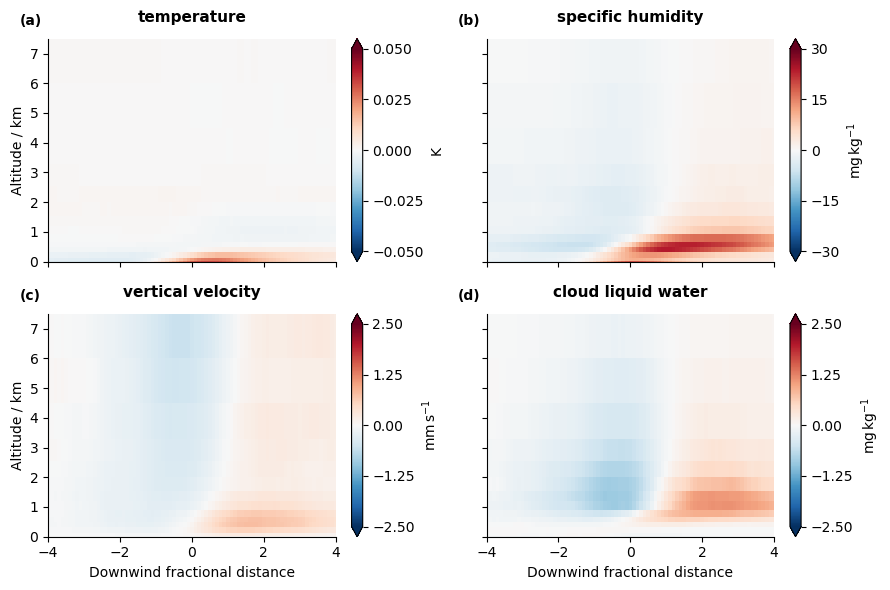

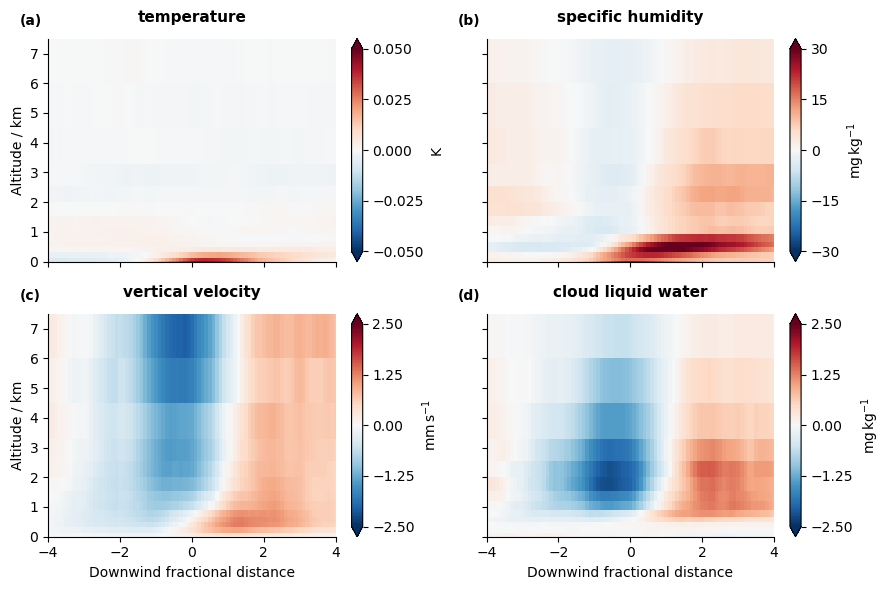

In [8]:
import importlib as implib
implib.reload(pcplot)

outpath = (
    f'/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/' +
    f'{analysis_idf}'
)
Path(outpath).mkdir(parents=True, exist_ok=True)

vars = ['ta_ano', 'hus_ano', 'wa_ano', 'clw_ano']
ysel = slice(38, 42)

alltrops_compo_adjusted = pccompo.adjust_units(alltrops_compo, vars)
pcplot.plot_compo_crosssection(alltrops_compo_adjusted, vars, ysel=ysel)
plt.savefig(
    f'{outpath}/{analysis_idf}_composite_crosssection_alltrops.png', dpi=600,
    )
plt.show()

rainbelt_compo_adjusted = pccompo.adjust_units(rainbelt_compo, vars)
pcplot.plot_compo_crosssection(rainbelt_compo_adjusted, vars, ysel=ysel)
plt.savefig(
    f'{outpath}/{analysis_idf}_composite_crosssection_rainbelt.png', dpi=600,
    )
plt.show()


### Plot subgroup composites

In [12]:
import importlib as implib
implib.reload(pcplot)

vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    ]

for var in subgroup_vars:
    for i in range(1, 5):
        alltrops_quartile_compo_adjusted = pccompo.adjust_units(
            alltrops_quartile_compo[var].sel(quartile=i), vars,
            )
        pcplot.plot_composite_overview(alltrops_quartile_compo_adjusted, vars)
        plt.savefig(
            f'/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/' +
            f'{analysis_idf}/{analysis_idf}_composite_alltrops_{var}q{i}_' +
            f'overview.png', dpi=600,
            )
        
        rainbelt_quartile_compo_adjusted = pccompo.adjust_units(
            rainbelt_quartile_compo[var].sel(quartile=i), vars,
            )
        pcplot.plot_composite_overview(rainbelt_quartile_compo_adjusted, vars)
        plt.savefig(
            f'/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/' +
            f'{analysis_idf}/{analysis_idf}_composite_rainbelt_{var}q{i}_' +
            f'overview.png', dpi=600,
            )

### Plot subgroup composites per variable

In [13]:
import hfplot.figure.figure as hffig
import importlib as implib
implib.reload(pcplot)

vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    'rlut_ano', 'prw_ano'
    ]
for var_plot in vars:
    fig, axs = hffig.init_subfig(
        style=None, asprat=(12.5, 13), nrow=4, ncol=3, sharex=True, sharey=True,
        )
    for v, var in enumerate(subgroup_vars):
        for i in range(0, 4):
            compo_data = pccompo.adjust_units(
                alltrops_quartile_compo[var].sel(quartile=i+1), vars,
                )

            if var_plot in ['hfls_ano', 'hfss_ano']:
                pl1 = axs[i, v].pcolormesh(
                    compo_data[var_plot]['En_rota2_featcen_x'],
                    compo_data[var_plot]['En_rota2_featcen_y'],
                    -1*compo_data[var_plot].transpose(),
                    cmap="RdBu_r", vmin=pcplot.COMPO_PLOT_RANGE[var_plot][0]*2.5,
                    vmax=pcplot.COMPO_PLOT_RANGE[var_plot][1]*2.5,
                )
            else:
                pl1 = axs[i, v].pcolormesh(
                    compo_data[var_plot]['En_rota2_featcen_x'],
                    compo_data[var_plot]['En_rota2_featcen_y'],
                    compo_data[var_plot].transpose(),
                    cmap="RdBu_r", vmin=pcplot.COMPO_PLOT_RANGE[var_plot][0]*2.5,
                    vmax=pcplot.COMPO_PLOT_RANGE[var_plot][1]*2.5,
                )
            pcplot._add_grid(
                axs[i, v],
                compo_data['En_rota2_featcen_x'], compo_data['En_rota2_featcen_y'],
                )
            pcplot._plot_feature_circle(axs[i, v], (0, 0), 1)
            axs[i, v].set_aspect('equal')
            axs[i, v].set_title(
                f"{var_plot},\n {var} q{i+1}", weight='bold', pad=12, fontsize=11,
                )
            #cbar_ticks = [
            #    COMPO_PLOT_RANGE[var][0], COMPO_PLOT_RANGE[var][0]/2, 0,
            #    COMPO_PLOT_RANGE[var][1]/2, COMPO_PLOT_RANGE[var][1], 
            #]
            plt.colorbar(
                pl1, ax=axs[i, v], label=pcplot.CLABEL_NICE[var_plot],
                extend='both', fraction=0.046, pad=0.05, #ticks=cbar_ticks,
                )
            hffig.set_label(
                axs, 'Downwind fractional distance', 'Crosswind fractional distance'
                )
        
    plt.tight_layout()
    plt.savefig(
        f'/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/' +
        f'{analysis_idf}/{analysis_idf}_composite_alltrops_{var_plot}_' +
        f'quartiles_overview.png', dpi=600,
        )


In [14]:
import hfplot.figure.figure as hffig
import importlib as implib
implib.reload(pcplot)

vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    ]
for var_plot in vars:
    fig, axs = hffig.init_subfig(
        style=None, asprat=(12.5, 13), nrow=4, ncol=3, sharex=True, sharey=True,
        )
    for v, var in enumerate(subgroup_vars):
        for i in range(0, 4):
            compo_data = pccompo.adjust_units(
                rainbelt_quartile_compo[var].sel(quartile=i+1), vars,
                )

            if var_plot in ['hfls_ano', 'hfss_ano']:
                pl1 = axs[i, v].pcolormesh(
                    compo_data[var_plot]['En_rota2_featcen_x'],
                    compo_data[var_plot]['En_rota2_featcen_y'],
                    -1*compo_data[var_plot].transpose(),
                    cmap="RdBu_r", vmin=pcplot.COMPO_PLOT_RANGE[var_plot][0]*2.5,
                    vmax=pcplot.COMPO_PLOT_RANGE[var_plot][1]*2.5,
                )
            else:
                pl1 = axs[i, v].pcolormesh(
                    compo_data[var_plot]['En_rota2_featcen_x'],
                    compo_data[var_plot]['En_rota2_featcen_y'],
                    compo_data[var_plot].transpose(),
                    cmap="RdBu_r", vmin=pcplot.COMPO_PLOT_RANGE[var_plot][0]*2.5,
                    vmax=pcplot.COMPO_PLOT_RANGE[var_plot][1]*2.5,
                )
            pcplot._add_grid(
                axs[i, v],
                compo_data['En_rota2_featcen_x'], compo_data['En_rota2_featcen_y'],
                )
            pcplot._plot_feature_circle(axs[i, v], (0, 0), 1)
            axs[i, v].set_aspect('equal')
            axs[i, v].set_title(
                f"{var_plot},\n {var} q{i+1}", weight='bold', pad=12, fontsize=11,
                )
            #cbar_ticks = [
            #    COMPO_PLOT_RANGE[var][0], COMPO_PLOT_RANGE[var][0]/2, 0,
            #    COMPO_PLOT_RANGE[var][1]/2, COMPO_PLOT_RANGE[var][1], 
            #]
            plt.colorbar(
                pl1, ax=axs[i, v], label=pcplot.CLABEL_NICE[var_plot],
                extend='both', fraction=0.046, pad=0.05, #ticks=cbar_ticks,
                )
            hffig.set_label(
                axs, 'Downwind fractional distance', 'Crosswind fractional distance'
                )
        
    plt.tight_layout()
    plt.savefig(
        f'/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/' +
        f'{analysis_idf}/{analysis_idf}_composite_rainbelt_{var_plot}_' +
        f'quartiles_overview.png', dpi=600,
        )


### Composite scatters

In [ ]:
var_duo = [
    ('ts_ano_laplacian', 'sfcwind_conv_ano'),
    ('ps_ano', 'sfcwind_conv_ano'),
    ('ts_ano', 'ts_ano_laplacian'),
    ('sfcwind_conv_ano', 'pr_ano'),
    ('ps_ano', 'sfcwind_ano')
]
var_group = 'bg_sfcwind'
vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    ]

for (x, y) in var_duo:
    alltrops_compo_adjusted = pccompo.adjust_units(alltrops_compo, vars)
    plt.scatter(
        alltrops_compo_adjusted[x], alltrops_compo_adjusted[y], label='All data',
        marker='.', alpha=0.5,
    )

    for i in range(0, 4):
        compo_data = pccompo.adjust_units(
            alltrops_quartile_compo[var_group].sel(quartile=i+1), vars,
            )
        plt.scatter(
        compo_data[x], compo_data[y], marker='.', alpha=0.5,
        label=f'{var_group} quartile {i+1}'
        )
        plt.legend()
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()

### Cuts along y=0

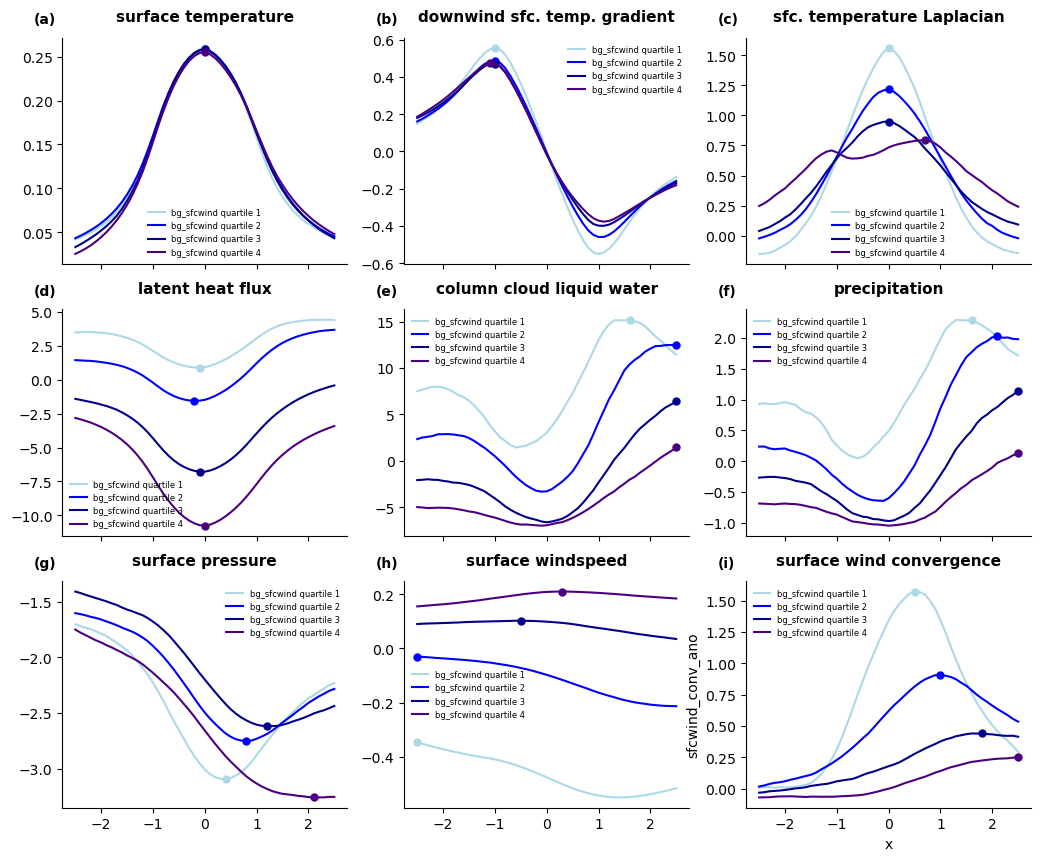

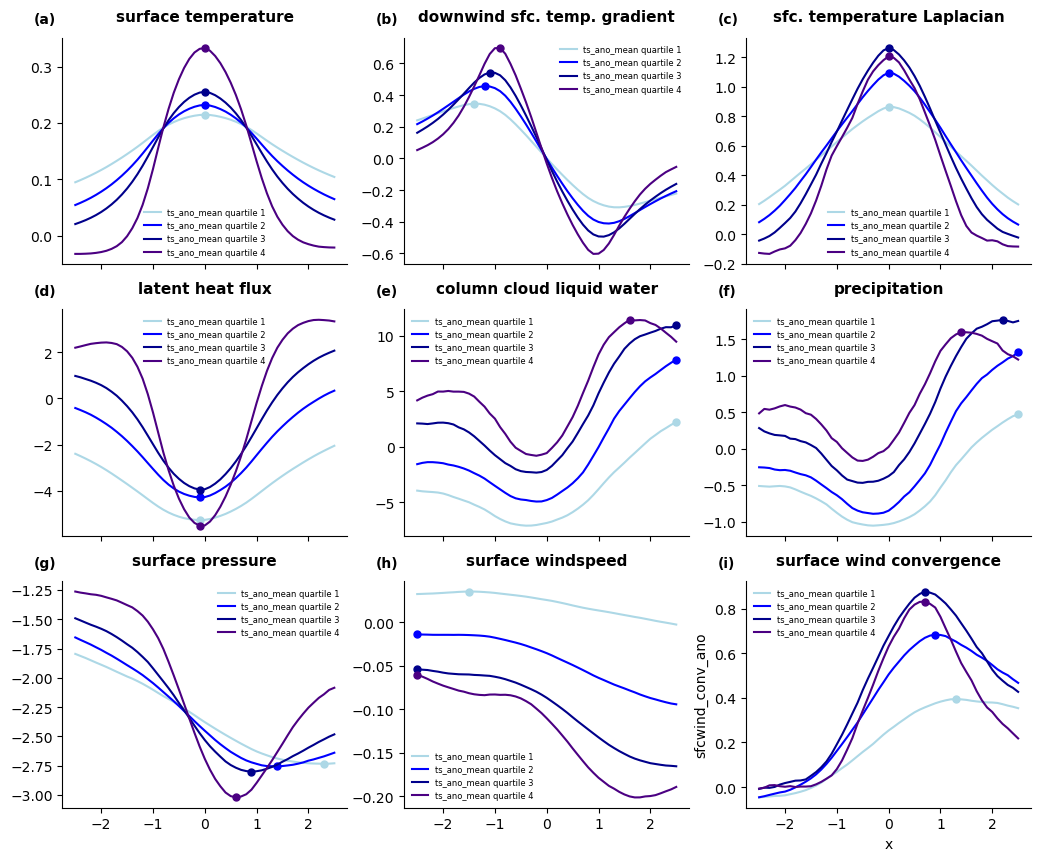

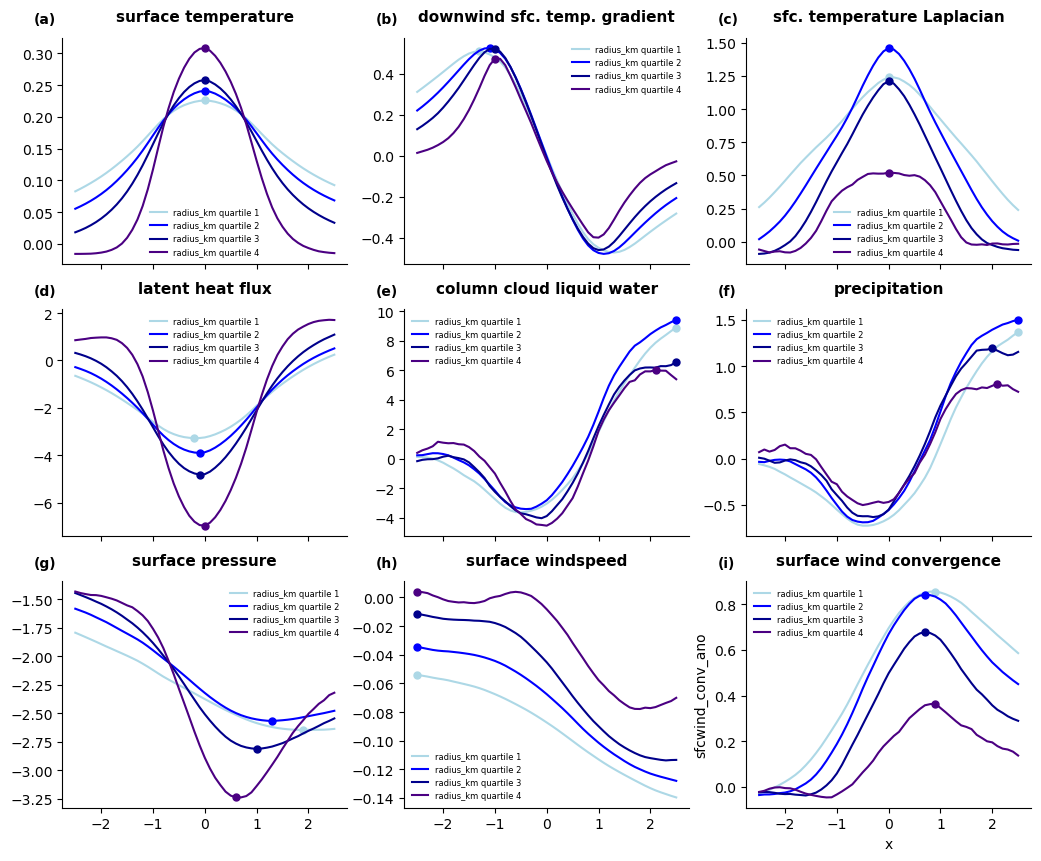

In [5]:
import hfplot.figure.figure as hffig
vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    ]
colors = ['lightblue', 'blue', 'darkblue', 'indigo']

vars_group = ['bg_sfcwind', 'ts_ano_mean', 'radius_km']
for var_group in vars_group:
    fig, axs = hffig.init_subfig(
        style=None, asprat=(12.5, 10), nrow=3, ncol=3, sharex=True, sharey=False,
        )
    for v, var in enumerate(vars):
        for i in range(0, 4):
            compo_data = pccompo.adjust_units(
                alltrops_quartile_compo[var_group].sel(quartile=i+1), vars,
                ).sel(y=25)
            axs.ravel()[v].plot(
                compo_data['En_rota2_featcen_x'], compo_data[var],
                label=f'{var_group} quartile {i+1}', color=colors[i]
            )
            if var in ['hfls_ano', 'ps_ano']:
                axs.ravel()[v].plot(
                    compo_data['En_rota2_featcen_x'].isel(
                        x=compo_data[var].argmin(dim='x').item()
                        ),
                    compo_data[var].min(), '.', color=colors[i], markersize=10
                    )
            else:
                axs.ravel()[v].plot(
                    compo_data['En_rota2_featcen_x'].isel(
                        x=compo_data[var].argmax(dim='x').item()
                        ),
                    compo_data[var].max(), '.', color=colors[i], markersize=10
                    )
        axs.ravel()[v].set_title(
            pcplot.COMPO_PLOT_LABEL[var], weight='bold', pad=12, fontsize=11,
            )
        axs.ravel()[v].legend(frameon=False, fontsize=6)
    plt.xlabel('x')
    plt.ylabel(var)
    plt.show()

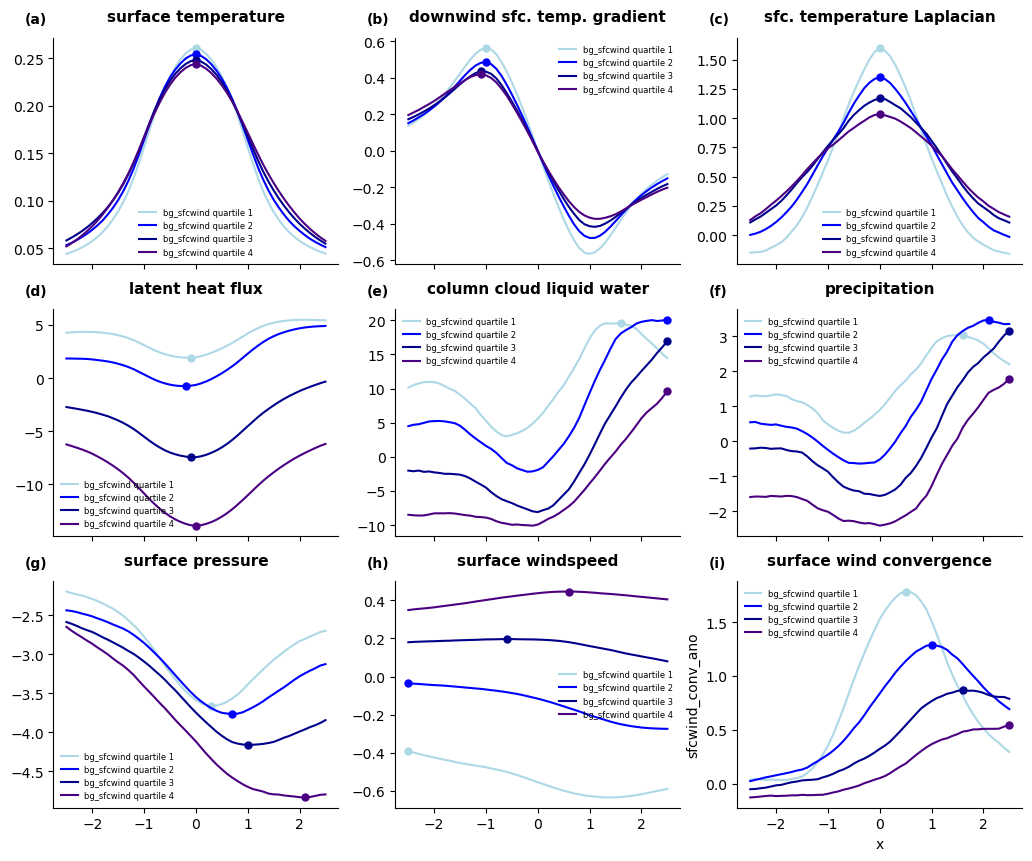

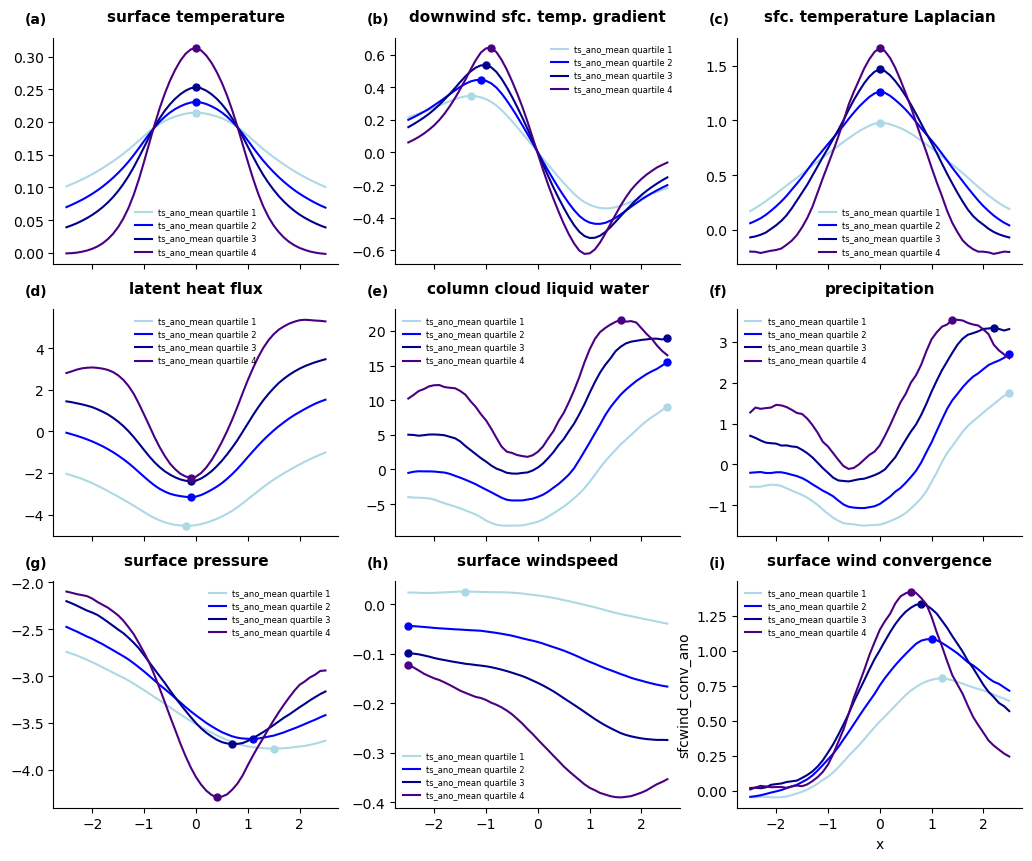

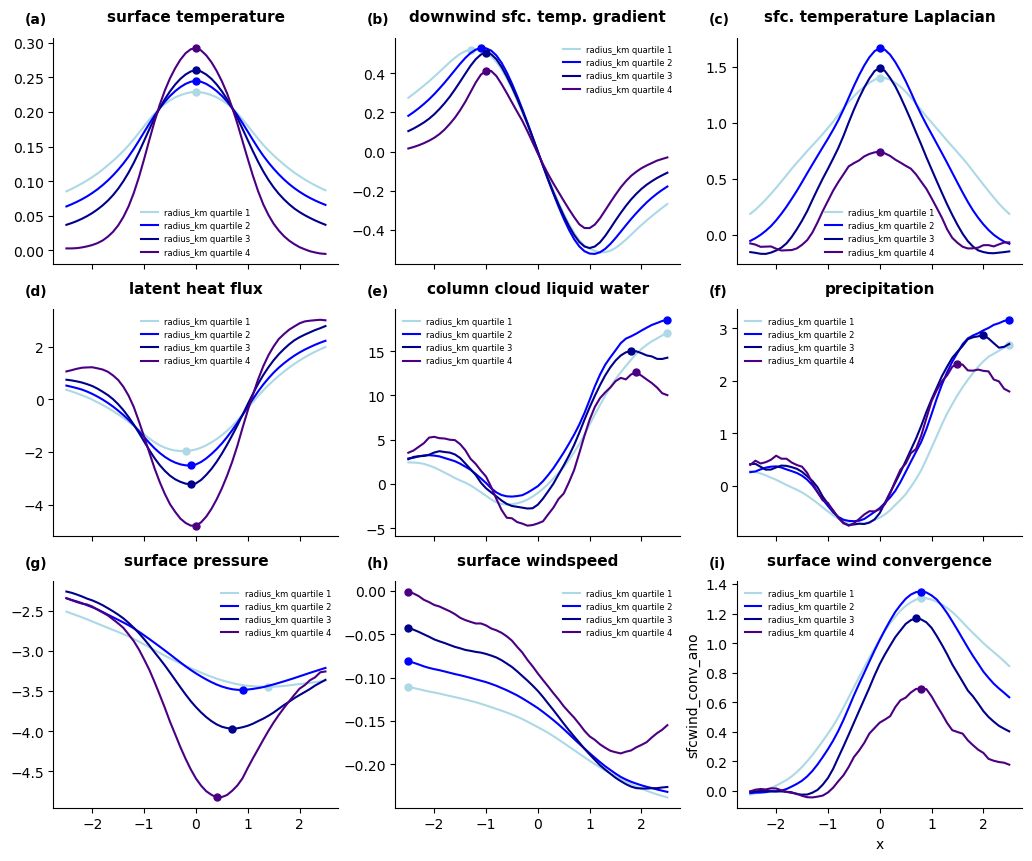

In [52]:
import hfplot.figure.figure as hffig
vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    ]
colors = ['lightblue', 'blue', 'darkblue', 'indigo']

vars_group = ['bg_sfcwind', 'ts_ano_mean', 'radius_km']
for var_group in vars_group:
    fig, axs = hffig.init_subfig(
        style=None, asprat=(12.5, 10), nrow=3, ncol=3, sharex=True, sharey=False,
        )
    for v, var in enumerate(vars):
        for i in range(0, 4):
            compo_data = pccompo.adjust_units(
                rainbelt_quartile_compo[var_group].sel(quartile=i+1), vars,
                ).sel(y=25)
            axs.ravel()[v].plot(
                compo_data['En_rota2_featcen_x'], compo_data[var],
                label=f'{var_group} quartile {i+1}', color=colors[i]
            )
            if var in ['hfls_ano', 'ps_ano']:
                axs.ravel()[v].plot(
                    compo_data['En_rota2_featcen_x'].isel(
                        x=compo_data[var].argmin(dim='x').item()
                        ),
                    compo_data[var].min(), '.', color=colors[i], markersize=10
                    )
            else:
                axs.ravel()[v].plot(
                    compo_data['En_rota2_featcen_x'].isel(
                        x=compo_data[var].argmax(dim='x').item()
                        ),
                    compo_data[var].max(), '.', color=colors[i], markersize=10
                    )
        axs.ravel()[v].set_title(
            pcplot.COMPO_PLOT_LABEL[var], weight='bold', pad=12, fontsize=11,
            )
        axs.ravel()[v].legend(frameon=False, fontsize=6)
    plt.xlabel('x')
    plt.ylabel(var)
    plt.show()

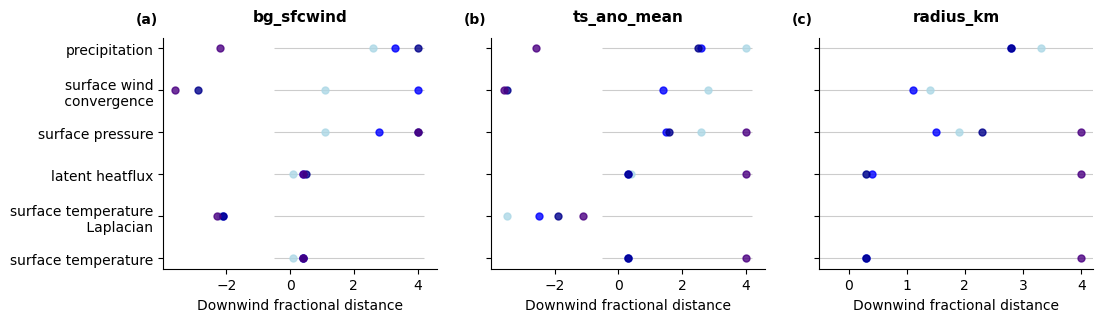

In [16]:
import hfplot.figure.figure as hffig
vars = [
    'ts_ano', 'ts_ano_laplacian', 'hfls_ano', 'ps_ano', 'sfcwind_conv_ano', 'pr_ano'
    ]
var_labels = [
    'surface temperature', 'surface temperature\n Laplacian', 'latent heatflux', 'surface pressure', 'surface wind\n convergence', 'precipitation'
    ]
colors = ['lightblue', 'blue', 'darkblue', 'indigo']

vars_group = ['bg_sfcwind', 'ts_ano_mean', 'radius_km']
fig, axs = hffig.init_subfig(
    style=None, asprat=(12, 3), nrow=1, ncol=3, offset_x=0, offset_y=0,
    sharex=False, sharey=True
    )
for g, var_group in enumerate(vars_group):
    for v, var in enumerate(vars):
        axs[0, g].hlines(
            v, xmin=-0.5, xmax=compo_data['En_rota2_featcen_x'].max()+0.2,
            color='black', linestyle='-', linewidth=0.8, alpha=0.2)
        for i in range(0, 4):
            compo_data = pccompo.adjust_units(
                alltrops_quartile_compo[var_group].sel(quartile=i+1), vars,
                ).sel(y=25)
            if var in ['hfls_ano', 'ps_ano']:
                axs[0, g].plot(
                    compo_data['En_rota2_featcen_x'].isel(
                        x=compo_data[var].argmin(dim='x').item()
                        ), v, '.', color=colors[i], markersize=10, alpha=0.8,
                    )
            else:
                axs[0, g].plot(
                    compo_data['En_rota2_featcen_x'].isel(
                        x=compo_data[var].argmax(dim='x').item()
                        ), v, '.', color=colors[i], markersize=10, alpha=0.8,
                    )
        axs[0, g].set_title(
            var_group, weight='bold', pad=12, fontsize=11,
            )
        #axs[0, 0].legend(frameon=False, fontsize=6)
    plt.xlim([-0.5, compo_data['En_rota2_featcen_x'].max()+0.2])
    axs[0, g].set_xlabel('Downwind fractional distance')
axs[0, 0].set_yticks(range(len(vars)))
axs[0, 0].set_yticklabels(var_labels)
plt.show()

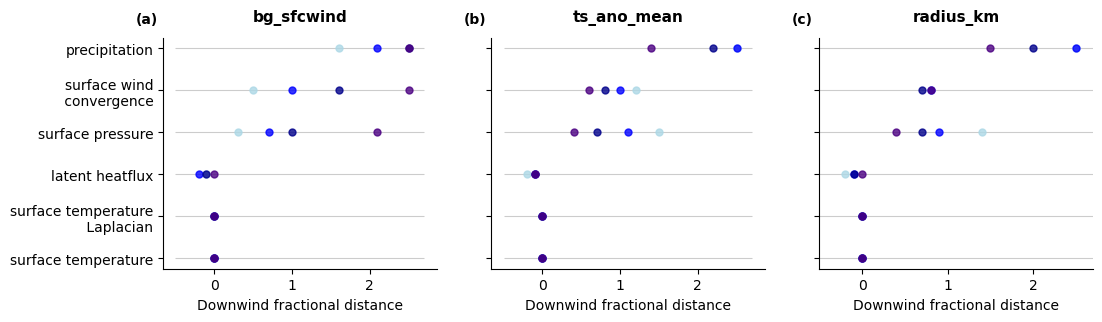

In [48]:
import hfplot.figure.figure as hffig
vars = [
    'ts_ano', 'ts_ano_laplacian', 'hfls_ano', 'ps_ano', 'sfcwind_conv_ano', 'pr_ano'
    ]
var_labels = [
    'surface temperature', 'surface temperature\n Laplacian', 'latent heatflux', 'surface pressure', 'surface wind\n convergence', 'precipitation'
    ]
colors = ['lightblue', 'blue', 'darkblue', 'indigo']

vars_group = ['bg_sfcwind', 'ts_ano_mean', 'radius_km']
fig, axs = hffig.init_subfig(
    style=None, asprat=(12, 3), nrow=1, ncol=3, offset_x=0, offset_y=0,
    sharex=False, sharey=True
    )
for g, var_group in enumerate(vars_group):
    for v, var in enumerate(vars):
        axs[0, g].hlines(
            v, xmin=-0.5, xmax=compo_data['En_rota2_featcen_x'].max()+0.2,
            color='black', linestyle='-', linewidth=0.8, alpha=0.2)
        for i in range(0, 4):
            compo_data = pccompo.adjust_units(
                rainbelt_quartile_compo[var_group].sel(quartile=i+1), vars,
                ).sel(y=25)
            if var in ['hfls_ano', 'ps_ano']:
                axs[0, g].plot(
                    compo_data['En_rota2_featcen_x'].isel(
                        x=compo_data[var].argmin(dim='x').item()
                        ), v, '.', color=colors[i], markersize=10, alpha=0.8,
                    )
            else:
                axs[0, g].plot(
                    compo_data['En_rota2_featcen_x'].isel(
                        x=compo_data[var].argmax(dim='x').item()
                        ), v, '.', color=colors[i], markersize=10, alpha=0.8,
                    )
        axs[0, g].set_title(
            var_group, weight='bold', pad=12, fontsize=11,
            )
        #axs[0, 0].legend(frameon=False, fontsize=6)
    plt.xlim([-0.5, compo_data['En_rota2_featcen_x'].max()+0.2])
    axs[0, g].set_xlabel('Downwind fractional distance')
axs[0, 0].set_yticks(range(len(vars)))
axs[0, 0].set_yticklabels(var_labels)
plt.show()

In [23]:
rainbelt_quartile_compo['bg_sfcwind']

<xarray.Dataset>
Dimensions:                (quartile: 4, component: 2, x: 81, y: 81)
Coordinates:
  * component              (component) object 'lat' 'lon'
    En_rota2_featcen_x     (x) float64 ...
    En_rota2_featcen_y     (y) float64 ...
  * quartile               (quartile) int64 1 2 3 4
Dimensions without coordinates: x, y
Data variables: (12/27)
    radius_km              (quartile) float64 ...
    area_km2               (quartile) float64 ...
    centroid_idx           (quartile, component) float64 ...
    axis_major_length_idx  (quartile) float64 ...
    axis_minor_length_idx  (quartile) float64 ...
    orientation_idx        (quartile) float64 ...
    ...                     ...
    rlut_ano               (quartile, x, y) float64 ...
    cllvi_ano              (quartile, x, y) float64 ...
    clivi_ano              (quartile, x, y) float64 ...
    sfcwind_ano            (quartile, x, y) float64 ...
    sfcwind_conv_ano       (quartile, x, y) float64 ...
    ps_ano                 (quartile, x, y) float64 ...

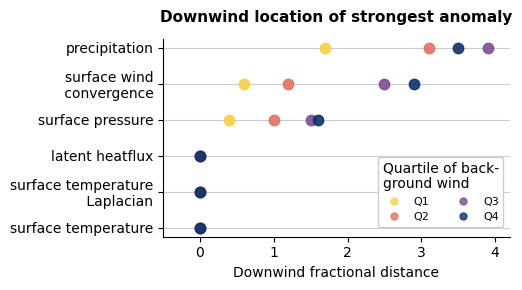

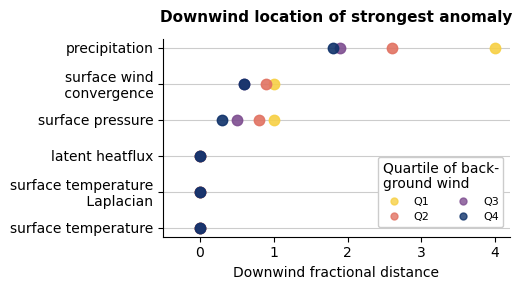

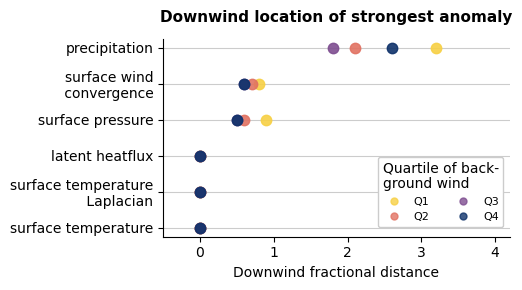

In [19]:
import hfplot.figure.figure as hffig
vars = [
    'ts_ano', 'ts_ano_laplacian', 'hfls_ano', 'ps_ano', 'sfcwind_conv_ano', 'pr_ano'
    ]
var_labels = [
    'surface temperature', 'surface temperature\n Laplacian', 'latent heatflux', 'surface pressure', 'surface wind\n convergence', 'precipitation'
    ]
colors = ['lightblue', 'blue', 'darkblue', 'indigo']
import cmocean
cmap = cmocean.cm.thermal_r
values = np.linspace(0.1, 0.9, 4)  # avoid extremes (0.0 and 1.0) if you want better contrast
colors = [cmap(v) for v in values]

vars_group = ['bg_sfcwind', 'ts_ano_mean', 'radius_km']
for var_group in vars_group:
    fig, axs = hffig.init_fig(style=None, asprat=(5.3, 3), offset_x=0, offset_y=0)
    for v, var in enumerate(vars):
        axs[0, 0].hlines(
            v, xmin=-0.5, xmax=compo_data['En_rota2_featcen_x'].max()+0.2,
            color='black', linestyle='-', linewidth=0.8, alpha=0.2)
        for i in range(0, 4):
            compo_data = pccompo.adjust_units(
                rainbelt_quartile_compo[var_group].sel(quartile=i+1), vars,
                ).sel(y=40)
            if v == 0:
                pl, = axs[0, 0].plot(
                    np.nan, np.nan, '.', color=colors[i], markersize=10,
                    alpha=0.8,
                    )
                pls = [pl] if i == 0 else pls + [pl]

            if var in ['hfls_ano', 'ps_ano', 'ts_ano_laplacian']:
                axs[0, 0].plot(
                    compo_data['En_rota2_featcen_x'].isel(
                        x=compo_data[var].argmin(dim='x').item()
                        ), v, '.', color=colors[i], markersize=15, alpha=0.9,
                    )
            else:
                axs[0, 0].plot(
                    compo_data['En_rota2_featcen_x'].isel(
                        x=compo_data[var].argmax(dim='x').item()
                        ), v, '.', color=colors[i], markersize=15, alpha=0.9,
                    )
        axs[0, 0].set_title(
            'Downwind location of strongest anomaly' , weight='bold', pad=12,
            fontsize=11,
            )
        axs[0, 0].legend(
            handles=pls, labels=['Q1', 'Q2', 'Q3', 'Q4'], ncol=2, framealpha=1.0,
            title='Quartile of back-\nground wind', fontsize=8, title_fontsize=10,
            loc=(0.62, 0.05),
            )
    plt.xlim([-0.5, compo_data['En_rota2_featcen_x'].max()+0.2])
    plt.xlabel('Downwind fractional distance')
    axs[0, 0].set_yticks(range(len(vars)))
    axs[0, 0].set_yticklabels(var_labels)
    plt.tight_layout()
    plt.savefig(
        f'/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/' +
        f'{analysis_idf}/{analysis_idf}_composite_rainbelt_downwind_location' +
        f'_{var_group}.png', dpi=600,
        )
    plt.show()

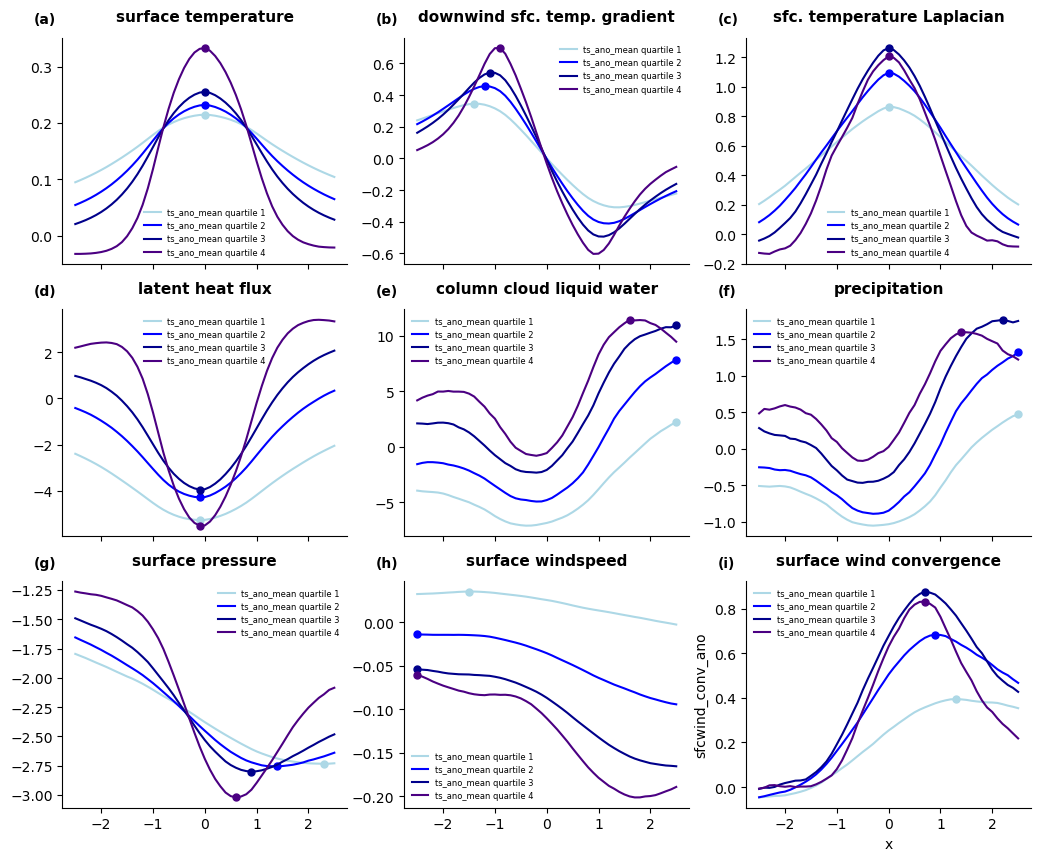

In [16]:
import hfplot.figure.figure as hffig
vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    ]
var_group = 'ts_ano_mean'
colors = ['lightblue', 'blue', 'darkblue', 'indigo']

fig, axs = hffig.init_subfig(
    style=None, asprat=(12.5, 10), nrow=3, ncol=3, sharex=True, sharey=False,
    )
for v, var in enumerate(vars):
    for i in range(0, 4):
        compo_data = pccompo.adjust_units(
            alltrops_quartile_compo[var_group].sel(quartile=i+1), vars,
            ).sel(y=25)
        axs.ravel()[v].plot(
            compo_data['En_rota2_featcen_x'], compo_data[var],
            label=f'{var_group} quartile {i+1}', color=colors[i]
        )
        if var in ['hfls_ano', 'ps_ano']:
            axs.ravel()[v].plot(
                compo_data['En_rota2_featcen_x'].isel(
                    x=compo_data[var].argmin(dim='x').item()
                    ),
                compo_data[var].min(), '.', color=colors[i], markersize=10
                )
        else:
            axs.ravel()[v].plot(
                compo_data['En_rota2_featcen_x'].isel(
                    x=compo_data[var].argmax(dim='x').item()
                    ),
                compo_data[var].max(), '.', color=colors[i], markersize=10
                )
    axs.ravel()[v].set_title(
        pcplot.COMPO_PLOT_LABEL[var], weight='bold', pad=12, fontsize=11,
        )
    axs.ravel()[v].legend(frameon=False, fontsize=6)
plt.xlabel('x')
plt.ylabel(var)
plt.show()

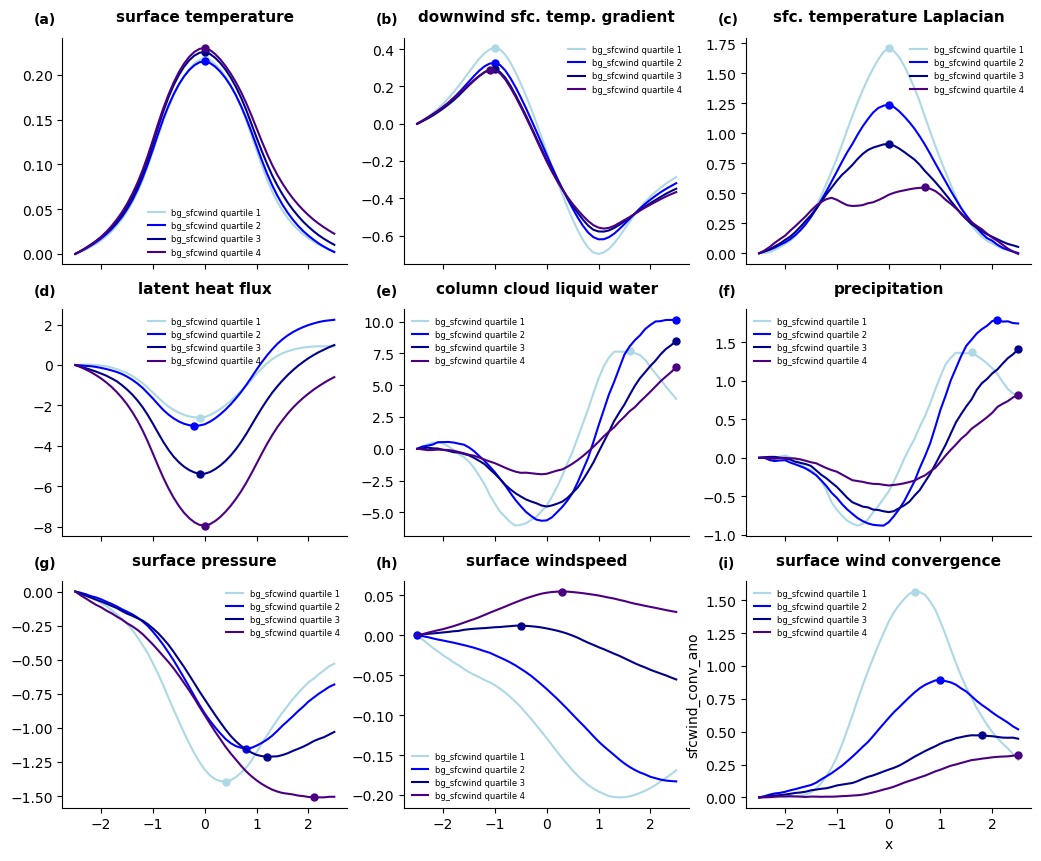

In [14]:
import hfplot.figure.figure as hffig
vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano',
    'cllvi_ano', 'pr_ano', 'ps_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    ]
var_group = 'bg_sfcwind'
colors = ['lightblue', 'blue', 'darkblue', 'indigo']

fig, axs = hffig.init_subfig(
    style=None, asprat=(12.5, 10), nrow=3, ncol=3, sharex=True, sharey=False,
    )
for v, var in enumerate(vars):
    for i in range(0, 4):
        compo_data = pccompo.adjust_units(
            alltrops_quartile_compo[var_group].sel(quartile=i+1), vars,
            ).sel(y=25)
        compo_data[var] = compo_data[var] - compo_data[var][0]
        axs.ravel()[v].plot(
            compo_data['En_rota2_featcen_x'], compo_data[var],
            label=f'{var_group} quartile {i+1}', color=colors[i]
        )
        if var in ['hfls_ano', 'ps_ano']:
            axs.ravel()[v].plot(
                compo_data['En_rota2_featcen_x'].isel(
                    x=compo_data[var].argmin(dim='x').item()
                    ),
                compo_data[var].min(), '.', color=colors[i], markersize=10
                )
        else:
            axs.ravel()[v].plot(
                compo_data['En_rota2_featcen_x'].isel(
                    x=compo_data[var].argmax(dim='x').item()
                    ),
                compo_data[var].max(), '.', color=colors[i], markersize=10
                )
    axs.ravel()[v].set_title(
        pcplot.COMPO_PLOT_LABEL[var], weight='bold', pad=12, fontsize=11,
        )
    axs.ravel()[v].legend(frameon=False, fontsize=6)
plt.xlabel('x')
plt.ylabel(var)
plt.show()

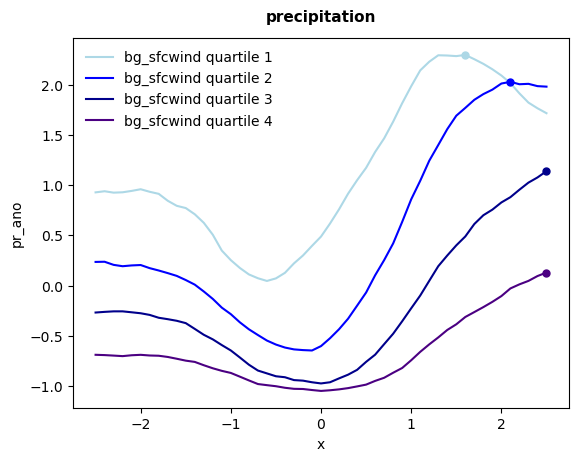

In [108]:
var = 'pr_ano'
colors = ['lightblue', 'blue', 'darkblue', 'indigo']
for i in range(0, 4):
    compo_data = pccompo.adjust_units(
        alltrops_quartile_compo['bg_sfcwind'].sel(quartile=i+1), vars,
        ).sel(y=25)
    plt.plot(
        compo_data['En_rota2_featcen_x'], compo_data[var],
        label=f'bg_sfcwind quartile {i+1}', color=colors[i]
    )
    plt.plot(
        compo_data['En_rota2_featcen_x'].isel(x=compo_data[var].argmax(dim='x').item()),
        compo_data[var].max(), '.', color=colors[i], markersize=10
        )
plt.gca().set_title(
    pcplot.COMPO_PLOT_LABEL[var], weight='bold', pad=12, fontsize=11,
    )
plt.legend(frameon=False)
plt.xlabel('x')
plt.ylabel(var)
plt.show()

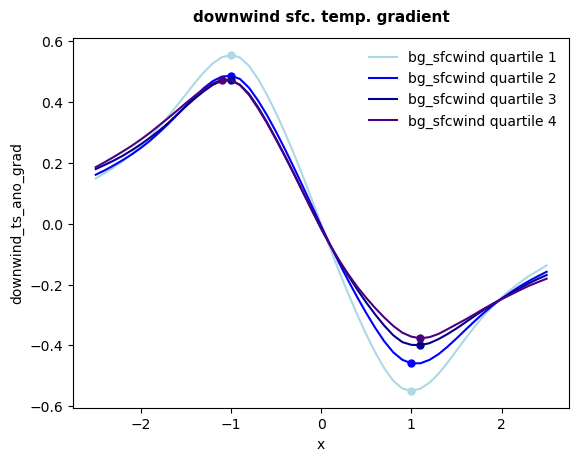

In [120]:
var = 'downwind_ts_ano_grad'
colors = ['lightblue', 'blue', 'darkblue', 'indigo']
for i in range(0, 4):
    compo_data = pccompo.adjust_units(
        alltrops_quartile_compo['bg_sfcwind'].sel(quartile=i+1), vars,
        ).sel(y=25)
    plt.plot(
        compo_data['En_rota2_featcen_x'], compo_data[var],
        label=f'bg_sfcwind quartile {i+1}', color=colors[i]
    )
    plt.plot(
        compo_data['En_rota2_featcen_x'].isel(x=compo_data[var].argmax(dim='x').item()),
        compo_data[var].max(), '.', color=colors[i], markersize=10
        )
    plt.plot(
        compo_data['En_rota2_featcen_x'].isel(x=compo_data[var].argmin(dim='x').item()),
        compo_data[var].min(), '.', color=colors[i], markersize=10
        )
plt.gca().set_title(
    pcplot.COMPO_PLOT_LABEL[var], weight='bold', pad=12, fontsize=11,
    )
plt.legend(frameon=False)
plt.xlabel('x')
plt.ylabel(var)
plt.show()

### Plot rainbelt subsampling mask

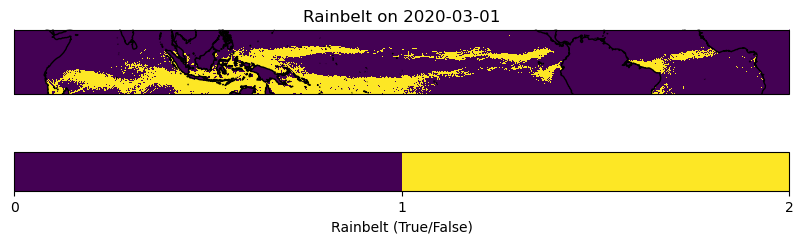

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-155))
rainbelt.sel(time=feature['time']).plot(
    ax=ax, transform=ccrs.PlateCarree(),
    levels=[0, 1, 2],
    cbar_kwargs={'label': 'Rainbelt (True/False)', 'orientation': 'horizontal'}
)
ax.coastlines()
ax.set_title(f"Rainbelt on {str(feature['time'].values)[:10]}")
plt.show()

fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-155))
pr_clim.sel(time=feature['time']).plot(
    ax=ax, transform=ccrs.PlateCarree(), 
    cbar_kwargs={'label': 'Pr (mm/day)', 'orientation': 'horizontal'},
    levels=np.arange(0,21,2)
)
ax.coastlines()
ax.set_title(f"Rainbelt on {str(feature['time'].values)[:10]}")
plt.show()